In [43]:
from __future__ import print_function

import os, sys, glob, json, string, re, time, warnings

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import emoji

import skimage.io
import scipy

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold

from sklearn.externals import joblib

from imblearn.ensemble import BalancedBaggingClassifier

from xgboost import XGBClassifier

from tqdm import tqdm_notebook as tqdm

import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

from alcohol_surveillance_utils import alcohol_keywords, other_keywords, alcohol_emoji_dict
from keyword_matching_utils import make_aho_keyword_automaton, find_keywords, has_any_keyword
from classify_alcohol_posts import InstagramAlcoholPostClassifier

%matplotlib inline
%load_ext autoreload
%autoreload 2

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['axes.grid'] = False
labelsize = 15
legendsize = 18
titlesize = 20
linewidth = 3
plt.gray()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
alcohol_kw_automaton = make_aho_keyword_automaton(alcohol_keywords)

cap = 'I love beer beerporn beerlover beerstagram whiseky cocktail alcohol !!!'

print(has_any_keyword(cap, alcohol_kw_automaton))
print(find_keywords(cap, alcohol_kw_automaton))

True
['beer', 'beer', 'beer', 'beerlove', 'beer', 'cocktail', 'alcohol']


### Train text classifiers for alcohol post identification

#### Load training data

In [3]:
df = pd.read_csv('data/nyc_labeled_180306.csv')
display(df)

_id      original.user.username  \
0     ObjectID(5a905b6ead3cd748dc8f5342)                  katedorlan   
1     ObjectID(5a905b6ead3cd748dc8f5343)                 tracymemoli   
2     ObjectID(5a905b6ead3cd748dc8f5344)             boston_beer_man   
3     ObjectID(5a905b6ead3cd748dc8f5345)                  chrstianco   
4     ObjectID(5a905b6ead3cd748dc8f5346)             ernie_nightlife   
5     ObjectID(5a905b6ead3cd748dc8f5347)           long.tongue.louie   
6     ObjectID(5a905b6ead3cd748dc8f5348)              robinson271088   
7     ObjectID(5a905b6ead3cd748dc8f5349)              collectors1946   
8     ObjectID(5a905b6ead3cd748dc8f534a)                     cdesens   
9     ObjectID(5a905b6ead3cd748dc8f534d)                solocreators   
10    ObjectID(5a905b6ead3cd748dc8f534e)                 elliemiabtq   
11    ObjectID(5a905b6ead3cd748dc8f534f)                  tita_kunna   
12    ObjectID(5a905b6ead3cd748dc8f5350)              robinson271088   
13    ObjectID(5a905b6ead3cd748dc8f5351)               alexusantiago   
14    ObjectID(5a905b6ead3cd748dc8f5353)                    sabian2u   
15    ObjectID(5a905b6ead3cd748dc8f5354)                  olivebahr_   
16    ObjectID(5a905b6ead3cd748dc8f5355)                      koogs5   
17    ObjectID(5a905b6ead3cd748dc8f5356)                 super_max24   
18    ObjectID(5a905b6ead3cd748dc8f5357)           mrs.butterfingers   
19    ObjectID(5a905b6ead3cd748dc8f5358)                 njrivera789   
20    ObjectID(5a905b6ead3cd748dc8f5359)                  boozinbums   
21    ObjectID(5a905b6ead3cd748dc8f535a)          mr.hand_bandchaser   
22    ObjectID(5a905b6ead3cd748dc8f535b)          alejandrofranconyc   
23    ObjectID(5a905b6ead3cd748dc8f535c)                    ayihs121   
24    ObjectID(5a905b6ead3cd748dc8f535d)               insiders_take   
25    ObjectID(5a905b6ead3cd748dc8f535e)      kyliekyliemartinmartin   
26    ObjectID(5a905b6ead3cd748dc8f5360)                     yocisco   
27    ObjectID(5a905b6ead3cd748dc8f5361)                 roseealimon   
28    ObjectID(5a905b6ead3cd748dc8f5362)              justin.pandelo   
29    ObjectID(5a905b6ead3cd748dc8f5363)                 _bigdiamond   
...                                  ...                         ...   
1056  ObjectID(5a905b6ead3cd748dc8f536e)             mhkunicornshark   
1057  ObjectID(5a905b6ead3cd748dc8f5370)                      7stix3   
1058  ObjectID(5a905b6ead3cd748dc8f5377)                   leefparks   
1059  ObjectID(5a905b6ead3cd748dc8f537a)               cakesbynerwan   
1060  ObjectID(5a905b6ead3cd748dc8f538e)           marcmillmanphotos   
1061  ObjectID(5a905b6ead3cd748dc8f53d2)               onecrazymoflo   
1062  ObjectID(5a905b6ead3cd748dc8f53db)             atlassocialclub   
1063  ObjectID(5a905b6ead3cd748dc8f53ee)               allorakitchen   
1064  ObjectID(5a905b6ead3cd748dc8f542a)         kevindiazrealestate   
1065  ObjectID(5a905b6ead3cd748dc8f542f)                 theatticnyc   
1066  ObjectID(5a905b6ead3cd748dc8f544f)       the.collective.action   
1067  ObjectID(5a905b6ead3cd748dc8f54a3)              missmuffydayla   
1068  ObjectID(5a905b6ead3cd748dc8f54aa)                     duomono   
1069  ObjectID(5a905b6ead3cd748dc8f54ac)                hoboken.dood   
1070  ObjectID(5a905b6ead3cd748dc8f54fe)             tequila.themutt   
1071  ObjectID(5a905b6ead3cd748dc8f550b)              candlecafewest   
1072  ObjectID(5a905b6ead3cd748dc8f5568)                  theoabbott   
1073  ObjectID(5a905b6ead3cd748dc8f5592)  belasantos_belabodyfitness   
1074  ObjectID(5a905b6fad3cd748dc8f55cc)              madeleinemarra   
1075  ObjectID(5a905b6fad3cd748dc8f55d2)              xoxo5mealsaday   
1076  ObjectID(5a905b6fad3cd748dc8f55e6)               thaitalian728   
1077  ObjectID(5a905b6fad3cd748dc8f5604)              rawritsjakelyn   
1078  ObjectID(5a905b6fad3cd748dc8f5633)                     tia_pol   
1079  ObjectID(5a905b6fad3cd748dc8f5649)              sleekstylemimi   
1080 

In [4]:
print(df['result'].value_counts(normalize=True))

print(df['result'].value_counts())

False    0.586556
True     0.413444
Name: result, dtype: float64
False    637
True     449
Name: result, dtype: int64


In [5]:
print(df['imageResult'].value_counts(normalize=True))

print(df['imageResult'].value_counts())

False    0.668203
True     0.331797
Name: imageResult, dtype: float64
False    725
True     360
Name: imageResult, dtype: int64


In [6]:
cap = df['original.caption.text'][9]
print(cap)

🔥 🔥 🔥 
#Rensta #Repost: @mr_coe via @renstapp #äcreatorspromo
···
“ Dope Commercial Piece I shot for a suit clothing line #rexbespoke | Follow @rexbespokeclothing for any suit needs, also official Brand Launch 3-31-18‼️ 🎥🎬 x @mr_coe #mackcali #amackcaliproduction #rexbespoke #suit #clothing #video #commercial #tailoredsuit #tailormade #tie #panasonicgh5 #brooklyn #manhattan #newjersey #videographer ”

#SOLOCREATORS 
WWW.SOLOCREATORS.COM

@iamkanos @villanomuzik @elblackhaze @mramazingamg @andreharrell


In [7]:
e = [c for c in cap.decode('utf-8') if c in emoji.UNICODE_EMOJI]
print(e)

[u'\U0001f525', u'\U0001f525', u'\U0001f525', u'\u203c', u'\U0001f3a5', u'\U0001f3ac']


#### Compute features

In [22]:
iap_classifier = InstagramAlcoholPostClassifier()
df_features = iap_classifier.compute_text_features(list(df['original.caption.text']), show_progress=True)
display(df_features)

100%|██████████| 1086/1086 [00:05<00:00, 193.11it/s]


count_absolut  count_admission  count_aguila  count_alcohol  \
0                 0                0             0              0   
1                 0                0             0              0   
2                 0                0             0              0   
3                 0                0             0              0   
4                 0                0             0              0   
5                 0                0             0              0   
6                 0                0             0              0   
7                 0                0             0              0   
8                 0                0             0              0   
9                 0                0             0              0   
10                0                0             0              0   
11                0                0             0              1   
12                0                0             0              0   
13                0                0             0              0   
14                0                0             0              0   
15                0                0             0              0   
16                0                0             0              0   
17                0                0             0              0   
18                0                0             0              0   
19                0                0             0              0   
20                0                0             0              0   
21                0                0             0              0   
22                0                0             0              0   
23                0                0             0              0   
24                0                0             0              0   
25                0                0             0              0   
26                0                0             0              0   
27                0                0             0              0   
28                0                0             0              0   
29                0                0             0              0   
...             ...              ...           ...            ...   
1056              0                0             0              0   
1057              0                0             0              1   
1058              0                0             0              0   
1059              0                0             0              0   
1060              0                0             0              0   
1061              0                0             0              0   
1062              0                0             0              0   
1063              0                0             0              0   
1064              0                0             0              0   
1065              0                0             0              0   
1066              0                0             0              0   
1067              0                0             0              0   
1068              0                0             0              0   
1069              0                0             0              0   
1070              0                0             0              0   
1071              0                0             0              0   
1072              0                0             0              0   
1073              0                0             0              0   
1074              0                0             0              0   
1075              0                0             0              0   
1076              0                0             0              0   
1077              0                0             0              0   
1078              0                0             0              0   
1079              0                0             0              0   
1080              0                0             0              0   
1081              0                0             0              0   
1082

In [23]:
X = scipy.sparse.csc_matrix(np.array(df_features.values, dtype='float'))
# X = np.array(df_features.values, dtype='float')
y = df['result'].values

print(X.shape, y.shape)

(1086, 176) (1086,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
neg_pos_ratio = (float(len(y_train)) - np.sum(y_train)) / np.sum(y_train)

print(X_train.shape, X_test.shape)
print(neg_pos_ratio)

(868, 176) (218, 176)
1.37808219178


#### Train random forest classifier

In [25]:
def score_classifier(params, cv=5):
    
    classifier_type = params['classifier_type']
    del params['classifier_type']
    
    clf = globals()[classifier_type](**params)
    
    score = np.mean(cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=-1))
 
    print("{:.4f}".format(score), end=' ')
    
    return {'loss': 1.0 - score, 'status': hyperopt.STATUS_OK}

def plot_roc_curve(X, y, models, model_names):
    
    if not isinstance(models, list):
        models = [models]
        model_names = [model_names]
    
    assert(len(models) == len(model_names))
    
    # Perforamnce of the model
    plt.figure()
        
    for model, model_name in zip(models, model_names):
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:,1])
        AUC  = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s (AUC = %0.4f)' % (model_name, AUC), linewidth=linewidth)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=labelsize)
    plt.ylabel('True Positive Rate', fontsize=labelsize)
    plt.title('ROC Curve', fontsize=titlesize)
    plt.legend(loc="lower right", fontsize=legendsize)
    plt.grid('on')
    plt.show()
    
def plot_pr_curve(X, y, models, model_names):
    
    if not isinstance(models, list):
        models = [models]
        model_names = [model_names]
    
    assert(len(models) == len(model_names))
    
    # Perforamnce of the model
    plt.figure()
        
    for model, model_name in zip(models, model_names):
        
        y_pred_prob = model.predict_proba(X)[:,1]
        p, r, _ = precision_recall_curve(y, y_pred_prob)
        
        AUC  = auc(r, p)
        AP = average_precision_score(y, y_pred_prob)
        plt.plot(r, p, label='%s (AUC = %0.4f, AP=%0.4f)' % (model_name, AUC, AP), linewidth=linewidth)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=labelsize)
    plt.ylabel('Precision', fontsize=labelsize)
    plt.title('PR Curve', fontsize=titlesize)
    plt.legend(loc="lower right", fontsize=legendsize)
    plt.grid('on')
    plt.show()
    
def get_balanced_subset(X, y, random_state=None):
    
    classes, counts = np.unique(y, return_counts=True)
    
    min_class_ind = np.argmin(counts)
    min_class_count = counts[min_class_ind]
    
    np.random.seed(random_state)
    
    sind = []
    
    for c in classes:
        
        cind = np.where(y.ravel() == c)[0]
        
        rind = np.random.choice(cind, min_class_count, replace=False)
        
        sind.extend(rind)
        
    sind = np.random.permutation(sind)
    
    X_bal = X[sind, :]
    y_bal = y[sind]
    
    return X_bal, y_bal    

In [26]:
rf_param_space = {
    'classifier_type': 'RandomForestClassifier',
    'n_estimators': scope.int(hp.qloguniform('n_estimators', np.log(10), np.log(1000), 1)),
    # 'n_estimators': scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'max_features': hp.pchoice('max_features', [
        (0.2, 'sqrt'),  # most common choice.
        (0.1, 'log2'),  # less common choice.
        (0.1, None),  # all features, less common choice.
        (0.6, hp.uniform('max_features.frac', 0., 1.))
    ]),
    'max_depth': hp.pchoice('max_depth', [
        (0.7, None),  # most common choice.
        # Try some shallow trees.
        (0.1, 2),
        (0.1, 3),
        (0.1, 4),
    ]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [
        1,  # most common choice.
        scope.int(hp.qloguniform('min_samples_leaf.gt1', np.log(1.5), np.log(50.5), 1))
    ]),
    # 'bootstrap': hp.choice('bootstrap', [True, False]),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'n_jobs': -1
}

In [27]:
%%time

trials = Trials()
best_rf_params = fmin(score_classifier, rf_param_space, algo=tpe.suggest, trials=trials, max_evals=100, 
                      rstate=np.random.RandomState(0))

best_rf_params = hyperopt.space_eval(rf_param_space, best_rf_params)
del best_rf_params['classifier_type']
print('\n\n', best_rf_params)

0.7143 0.7016 0.7177 0.7293 0.7028 0.6993 0.7039 0.7246 0.6832 0.6820 0.7120 0.5795 0.7143 0.6843 0.7315 0.7131 0.6958 0.7292 0.6982 0.7177 0.7465 0.7431 0.7419 0.7431 0.7431 0.7063 0.7431 0.7408 0.6947 0.7431 0.7327 0.7385 0.7431 0.7477 0.7304 0.7362 0.7454 0.7292 0.7178 0.7166 0.5795 0.6970 0.7097 0.6705 0.6993 0.7384 0.6912 0.7443 0.7062 0.7097 0.7235 0.5795 0.7339 0.7200 0.7419 0.6935 0.7350 0.7200 0.7235 0.5795 0.7408 0.7131 0.7212 0.7178 0.7039 0.7293 0.7419 0.7224 0.7166 0.7223 0.7373 0.7281 0.7408 0.6935 0.7419 0.7281 0.7270 0.7327 0.7246 0.5795 0.7408 0.7177 0.7224 0.6993 0.5795 0.7212 0.7362 0.7292 0.6429 0.7235 0.6152 0.7200 0.7269 0.7224 0.6797 0.7235 0.7338 0.7166 0.7154 0.7281 

 {'n_estimators': 79, 'n_jobs': -1, 'criterion': 'gini', 'max_features': 'log2', 'max_depth': None, 'min_samples_leaf': 1}
CPU times: user 15 s, sys: 11.7 s, total: 26.8 s
Wall time: 2min 37s


In [28]:
best_rf_model = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(**best_rf_params),
                                          n_estimators=5, n_jobs=-1)
best_rf_model.fit(X_train, y_train)

y_test_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

print("Accuracy = {}".format(accuracy_score(y_test, y_test_pred)))

y_test_pred_prob = best_rf_model.predict_proba(X_test)
print("AUC = {}".format(roc_auc_score(y_test, y_test_pred_prob[:, 1])))
print("AP = {}".format(average_precision_score(y_test, y_test_pred_prob[:, 1])))

             precision    recall  f1-score   support

      False       0.79      0.75      0.77       134
       True       0.63      0.69      0.66        84

avg / total       0.73      0.72      0.73       218

Accuracy = 0.724770642202
AUC = 0.80907960199
AP = 0.746479530962


In [29]:
joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

#### Train XGBoost classifier

In [30]:
xgb_param_space = {
    'classifier_type': 'XGBClassifier',
    'max_depth': scope.int(hp.quniform('max_depth', 1, 11, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(5)) - 0.0001,
    'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(100)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(4)),
}

In [31]:
%%time

trials = Trials()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    best_xgb_params = fmin(score_classifier, xgb_param_space, algo=tpe.suggest, trials=trials, max_evals=100, 
                           rstate=np.random.RandomState(0))

best_xgb_params = hyperopt.space_eval(xgb_param_space, best_xgb_params)
del best_xgb_params['classifier_type']
print('\n\n', best_xgb_params)

0.6924 0.6843 0.7258 0.7258 0.6843 0.7063 0.7177 0.6993 0.7062 0.6982 0.7166 0.7005 0.5795 0.6912 0.7143 0.7131 0.7120 0.6889 0.7189 0.6958 0.7201 0.7086 0.6947 0.7189 0.7120 0.7258 0.7062 0.7189 0.7212 0.6958 0.6890 0.7120 0.7028 0.7177 0.7373 0.7350 0.7235 0.7039 0.7373 0.5795 0.7051 0.6866 0.7270 0.6912 0.7074 0.7005 0.7350 0.7350 0.6913 0.6936 0.7039 0.7258 0.7016 0.7005 0.7177 0.7189 0.7132 0.7143 0.7293 0.7108 0.7028 0.7016 0.7327 0.7074 0.6808 0.7419 0.7327 0.7316 0.7316 0.7258 0.7166 0.7097 0.7235 0.7327 0.7327 0.7200 0.7166 0.6913 0.5795 0.7074 0.7235 0.7339 0.7246 0.7028 0.6982 0.7108 0.6993 0.7108 0.7419 0.7212 0.7281 0.7178 0.7016 0.6820 0.7166 0.7465 0.7454 0.7431 0.7247 0.7385 

 {'reg_alpha': 0.019437339546293893, 'colsample_bytree': 0.7324147237887513, 'colsample_bylevel': 0.6521076623264487, 'learning_rate': 0.09373725036915358, 'min_child_weight': 1.2408905227982427, 'n_estimators': 996, 'subsample': 0.8811231876569954, 'reg_lambda': 3.3884100399554384, 'max_depth': 2

In [32]:
best_xgb_model = BalancedBaggingClassifier(base_estimator=XGBClassifier(**best_xgb_params),
                                           n_estimators=5, n_jobs=-1)

best_xgb_model.fit(X_train, y_train)

y_test_pred = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

print("Accuracy = {}".format(accuracy_score(y_test, y_test_pred)))

y_test_pred_prob = best_xgb_model.predict_proba(X_test)
print("AUC = {}".format(roc_auc_score(y_test, y_test_pred_prob[:, 1])))
print("AP = {}".format(average_precision_score(y_test, y_test_pred_prob[:, 1])))

             precision    recall  f1-score   support

      False       0.81      0.71      0.75       134
       True       0.61      0.73      0.66        84

avg / total       0.73      0.72      0.72       218

Accuracy = 0.715596330275
AUC = 0.805348258706
AP = 0.751532637268


In [33]:
joblib.dump(best_xgb_model, 'best_xgboost_model.pkl')

['best_xgboost_model.pkl']

#### Train Multinomial Naive Bayes classifier

In [34]:
nb_param_space = {
    'classifier_type': 'MultinomialNB',
    'alpha': hp.quniform('alpha', 0.01, 1., 0.001),
    'fit_prior': hp.choice('fit_prior', [False, True])
}

In [35]:
%%time

trials = Trials()
best_nb_params = fmin(score_classifier, nb_param_space, algo=tpe.suggest, trials=trials, max_evals=100, 
                       rstate=np.random.RandomState(0))

best_nb_params = hyperopt.space_eval(nb_param_space, best_nb_params)
del best_nb_params['classifier_type']
print('\n\n', best_nb_params)

0.7547 0.7420 0.7454 0.7535 0.7477 0.7431 0.7443 0.7570 0.7397 0.7535 0.7454 0.7477 0.7558 0.7570 0.7477 0.7454 0.7501 0.7558 0.7558 0.7431 0.7570 0.7570 0.7570 0.7570 0.7558 0.7558 0.7581 0.7581 0.7581 0.7558 0.7570 0.7570 0.7570 0.7581 0.7593 0.7558 0.7512 0.7570 0.7593 0.7478 0.7454 0.7558 0.7466 0.7581 0.7477 0.7547 0.7558 0.7454 0.7570 0.7501 0.7431 0.7570 0.7466 0.7454 0.7535 0.7512 0.7558 0.7454 0.7570 0.7570 0.7593 0.7431 0.7581 0.7466 0.7558 0.7570 0.7581 0.7547 0.7581 0.7570 0.7581 0.7581 0.7570 0.7581 0.7558 0.7558 0.7535 0.7558 0.7454 0.7558 0.7512 0.7593 0.7593 0.7454 0.7547 0.7478 0.7570 0.7558 0.7454 0.7535 0.7581 0.7558 0.7489 0.7581 0.7581 0.7581 0.7443 0.7558 0.7570 0.7570 

 {'alpha': 0.488, 'fit_prior': False}
CPU times: user 12.9 s, sys: 12.2 s, total: 25 s
Wall time: 36 s


In [36]:
best_nb_model = BalancedBaggingClassifier(base_estimator=MultinomialNB(**best_nb_params),
                                          n_estimators=5, n_jobs=-1)
best_nb_model.fit(X_train, y_train)

y_test_pred = best_nb_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

print("Accuracy = {}".format(accuracy_score(y_test, y_test_pred)))

y_test_pred_prob = best_nb_model.predict_proba(X_test)
print("AUC = {}".format(roc_auc_score(y_test, y_test_pred_prob[:, 1])))
print("AP = {}".format(average_precision_score(y_test, y_test_pred_prob[:, 1])))

             precision    recall  f1-score   support

      False       0.82      0.73      0.77       134
       True       0.64      0.75      0.69        84

avg / total       0.75      0.74      0.74       218

Accuracy = 0.738532110092
AUC = 0.807302771855
AP = 0.667371362878


#### Train Neural Network Classifier

In [37]:
nn_param_space = {
    'classifier_type': 'MLPClassifier',
    'hidden_layer_sizes': scope.int(hp.quniform('hidden_layer_sizes', 25, 100, 1)),
    'alpha': hp.lognormal('alpha', mu=np.log(1e-4), sigma=1),
    'learning_rate_init': hp.loguniform('learning_rate_init', low=np.log(1e-4), high=np.log(1.)),
    'max_iter': 1000
}

In [38]:
%%time

trials = Trials()
best_nn_params = fmin(
    score_classifier, nn_param_space, algo=tpe.suggest, trials=trials, max_evals=100, 
    rstate=np.random.RandomState(0)
)

best_nn_params = hyperopt.space_eval(nn_param_space, best_nn_params)
del best_nn_params['classifier_type']
print('\n\n', best_nn_params)

0.7027 0.7061 0.7212 0.7224 0.7328 0.7328 0.6048 0.5795 0.7246 0.6751 0.6706 0.6924 0.7154 0.7338 0.7213 0.7281 0.5795 0.6959 0.6165 0.7132 0.5737 0.7224 0.7362 0.7443 0.7328 0.6935 0.7305 0.5795 0.7246 0.5795 0.7132 0.6450 0.5749 0.7027 0.7212 0.7247 0.6360 0.7132 0.5762 0.7373 0.6945 0.5806 0.5795 0.5968 0.5795 0.5841 0.6681 0.5795 0.6924 0.6935 0.7397 0.5795 0.7109 0.6704 0.6856 0.7397 0.5795 0.7178 0.7098 0.7339 0.6534 0.5795 0.7143 0.7292 0.7178 0.7327 0.7362 0.7143 0.7200 0.7327 0.5795 0.6785 0.6693 0.6992 0.7132 0.6336 0.7339 0.7293 0.7316 0.6730 0.7040 0.5864 0.7362 0.5933 0.7166 0.5795 0.7178 0.7454 0.6958 0.6186 0.7282 0.7017 0.7259 0.6901 0.7166 0.5795 0.7454 0.7224 0.5818 0.7201 

 {'alpha': 3.4751168050988236e-06, 'max_iter': 1000, 'learning_rate_init': 0.0006412052379192511, 'hidden_layer_sizes': 51}
CPU times: user 12.9 s, sys: 12.2 s, total: 25.2 s
Wall time: 2min 17s


In [39]:
best_nn_model = BalancedBaggingClassifier(base_estimator=MLPClassifier(**best_nn_params),
                                          n_estimators=5, n_jobs=-1)
best_nn_model.fit(X_train, y_train)

y_test_pred = best_nn_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

print("Accuracy = {}".format(accuracy_score(y_test, y_test_pred)))

y_test_pred_prob = best_nn_model.predict_proba(X_test)
print("AUC = {}".format(roc_auc_score(y_test, y_test_pred_prob[:, 1])))
print("AP = {}".format(average_precision_score(y_test, y_test_pred_prob[:, 1])))

             precision    recall  f1-score   support

      False       0.72      0.88      0.79       134
       True       0.71      0.46      0.56        84

avg / total       0.72      0.72      0.70       218

Accuracy = 0.720183486239
AUC = 0.775319829424
AP = 0.715908811185


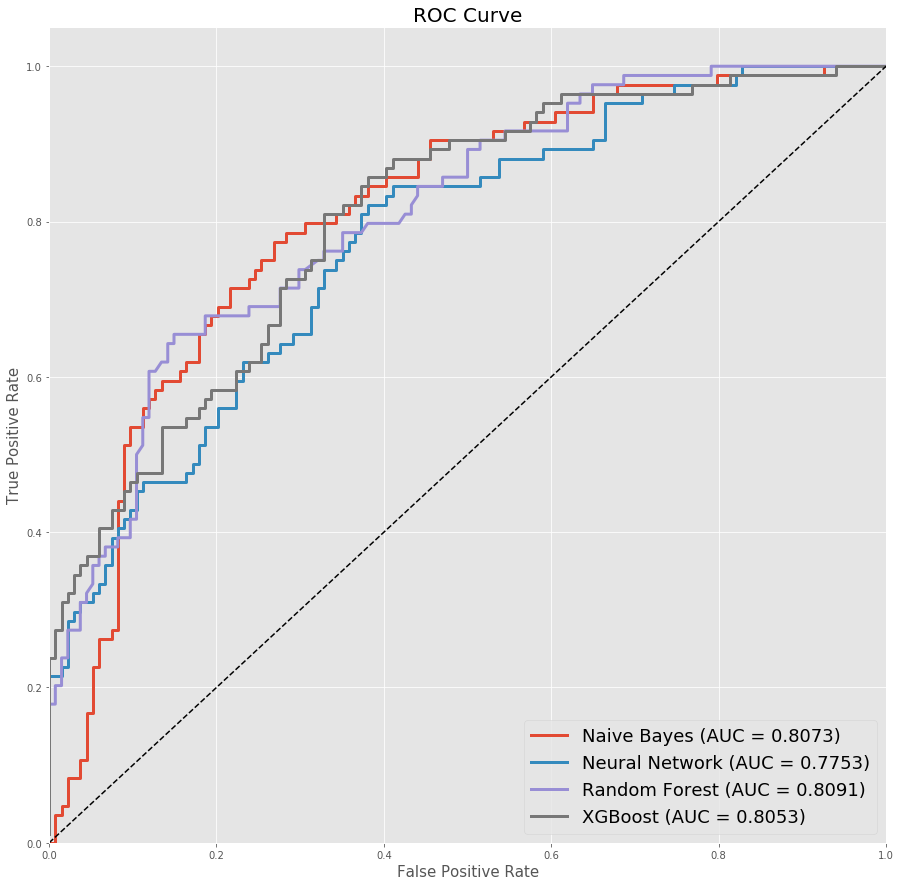

In [44]:
plot_roc_curve(
    X_test, y_test, 
    [best_nb_model, best_nn_model, best_rf_model, best_xgb_model],
    ['Naive Bayes', 'Neural Network', 'Random Forest', 'XGBoost']
)

In [45]:
plot_pr_curve(
    X_test, y_test, 
    [best_nb_model, best_nn_model, best_rf_model, best_xgb_model],
    ['Naive Bayes', 'Neural Network', 'Random Forest', 'XGBoost']
)